# Leakage assessment

In [33]:
import numpy as np, tqdm, matplotlib.pyplot as plt
from h5py import File
from sklearn.cluster import KMeans

In [34]:
from sklearn.manifold import TSNE

In [35]:
def running_mean_cumsum(x, N):
    # running mean to smooth the plots
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [36]:
# next should'nt be modified
NTRU_N = 509
NTRU_LOGQ = 11
NTRU_Q = (1 << NTRU_LOGQ)

N = 507 # number of coeff/peaks extracted (do not change)
dim_traces = 950

In [111]:
with File("./data/data_LA.h5","r") as f_data:
    traces = np.array(f_data["traces"], dtype='int8')
print(traces.shape)

<HDF5 dataset "traces": shape (15, 507, 950), type "|i1">
(15, 507, 950)


In [38]:
from sklearn.metrics import davies_bouldin_score

def CSR(Y):
    bc = np.bincount(Y)
    return np.abs(np.min(bc)/np.max(bc)-0.5)

def poi_search(T,x_range):
    # T: traces, x_range: x's to test

    metric_dbi = [] # Davies-Bouldin indices
    metric_csr = [] # CSR metric
    metric_dist = []# distance of centroids
    
    for x in tqdm.tqdm(x_range):
        X = T[:,x].reshape((-1,1))
        km = KMeans(n_clusters=2, random_state=0).fit(X)
        Y = km.labels_
        
        metric_dbi.append(davies_bouldin_score(X, Y))
        
        metric_csr.append(CSR(Y))
        
        metric_dist.append(np.abs(np.sum((km.cluster_centers_[0]-km.cluster_centers_[1]))))
        
    metric_dbi = np.array(metric_dbi)
    metric_csr = np.array(metric_csr)
    metric_dist = np.array(metric_dist)
    
    return metric_dbi,metric_csr,metric_dist

## First leakage assessment

We try to identify where the $-1$'s leak more than $0/1$.

In [6]:
T = traces.reshape((traces.shape[0]*traces.shape[1],traces.shape[2]))
metric_dbi,metric_csr,metric_dist = poi_search(T,np.arange(0,traces.shape[2],1))

100%|██████████| 950/950 [00:19<00:00, 49.68it/s]


As shown below, there is a promising area where clusters are well-formed and of the expected size.

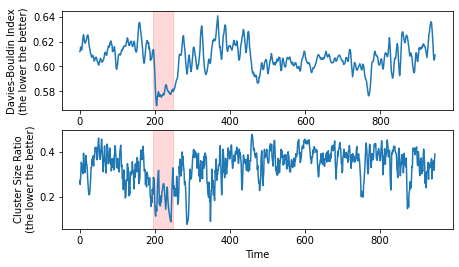

In [7]:
f, (ax1, ax2) = plt.subplots(2, sharey=False, figsize=(7,4))

ax1.plot(running_mean_cumsum(metric_dbi,5))
ax2.plot(running_mean_cumsum(metric_csr,4))
ax1.set_ylabel('Davies-Bouldin Index\n(the lower the better)')
ax2.set_ylabel('Cluster Size Ratio\n(the lower the better)')

ax2.set_xlabel('Time')

x0, x1 = 195, 250

ax1.axvspan(x0, x1-1, alpha=0.15, color='r')
ax2.axvspan(x0, x1-1, alpha=0.15, color='r')

plt.show()

## Second leakage assessment

As explained in the article, we perform the assessment on the absolute difference of consecutive peaks to identify the collisions (same data and instructions due to the processing of a $0$).

We know that the area of interest is located in the second half of the traces.

When performing the assessment on all the time samples, depending if we use the difference of absolute difference of traces, we observe that the metrics do not provide completely consistent results. However, some areas of interest are clearly highlighted.

For instance, we focus on the part of the area colored in red where the CSR and distance-between-centroids metrics give consistent results for the difference of traces.

In [107]:
T_diff = (traces[:,1:]-traces[:,:-1]).reshape((traces.shape[0]*(traces.shape[1]-1),traces.shape[2]))
metric_dbi_diff,metric_csr_diff,metric_dist_diff = poi_search(T_diff,np.arange(0,traces.shape[2]))

100%|██████████| 950/950 [02:23<00:00,  6.63it/s]


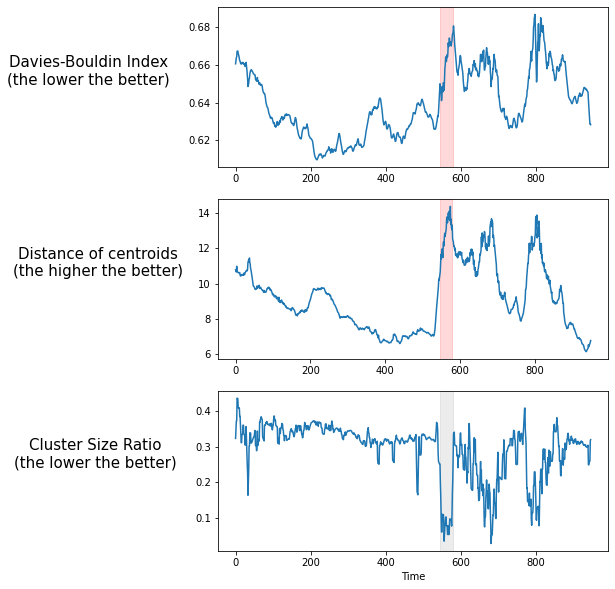

In [108]:
f, (ax1, ax2, ax3) = plt.subplots(3, sharey=False, figsize=(7,10))

ax1.plot(running_mean_cumsum(metric_dbi_diff,5))#[540:850])
ax2.plot(metric_dist_diff)
ax3.plot(running_mean_cumsum(metric_csr_diff,5))

ax1.set_ylabel('Davies-Bouldin Index\n(the lower the better)', size=15, rotation=0, labelpad=100)
ax2.set_ylabel('Distance of centroids\n(the higher the better)', size=15, rotation=0, labelpad=100)
ax3.set_ylabel('Cluster Size Ratio\n(the lower the better)', size=15, rotation=0, labelpad=100)

ax3.set_xlabel('Time')

x0, x1 = 545, 580

ax1.axvspan(x0, x1-1, alpha=0.15, color='r')
ax2.axvspan(x0, x1-1, alpha=0.15, color='r')
ax3.axvspan(x0, x1-1, alpha=0.15, color='grey')

plt.show()

In [109]:
T_diff = np.abs(traces[:,1:]-traces[:,:-1]).reshape((traces.shape[0]*(traces.shape[1]-1),traces.shape[2]))
metric_dbi_diff,metric_csr_diff,metric_dist_diff = poi_search(T_diff,np.arange(0,traces.shape[2]))

100%|██████████| 950/950 [01:01<00:00, 15.36it/s]


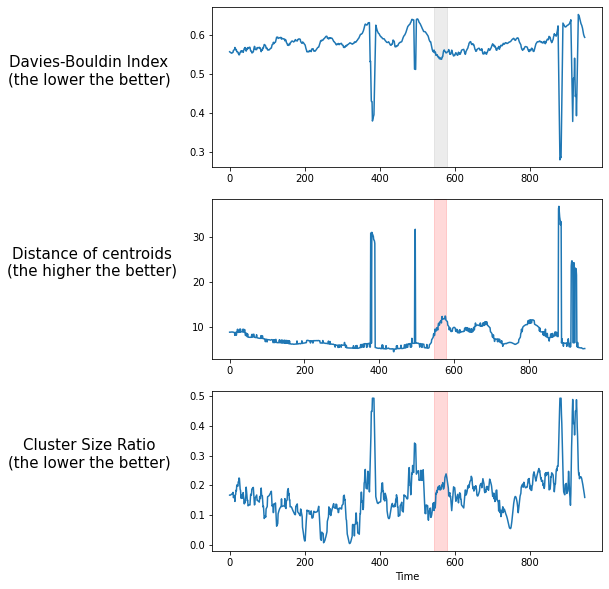

In [110]:
f, (ax1, ax2, ax3) = plt.subplots(3, sharey=False, figsize=(7,10))

ax1.plot(running_mean_cumsum(metric_dbi_diff,5))
ax2.plot(metric_dist_diff)
ax3.plot(running_mean_cumsum(metric_csr_diff,5))

ax1.set_ylabel('Davies-Bouldin Index\n(the lower the better)', size=15, rotation=0, labelpad=100)
ax2.set_ylabel('Distance of centroids\n(the higher the better)', size=15, rotation=0, labelpad=100)
ax3.set_ylabel('Cluster Size Ratio\n(the lower the better)', size=15, rotation=0, labelpad=100)

ax3.set_xlabel('Time')

x0, x1 = 545, 580

ax1.axvspan(x0, x1-1, alpha=0.15, color='grey')
ax2.axvspan(x0, x1-1, alpha=0.15, color='r')
ax3.axvspan(x0, x1-1, alpha=0.15, color='r')

plt.show()